# Regression Tree

It's time to design our generic regression tree model that can be applied to any player. It will be based on the regression tree we designed using Federer as an exemple.

In [1]:
### IMPORTS ###

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We select the player and generate a table containing that player's matches which we will store in "player.csv", as to avoid creating one table for each player.  
Note : This setup step has to be repeated each time we change players.

In [44]:
### CLEAN PLAYER MATCHES TABLES ###

PLAYER = "Alexander Zverev"
setup = False

if (setup) :    # Creating the table (if the player.csv table currently contains information for another player)

    atp = pd.read_csv("atp_cat.csv")

    player_won = atp[atp["winner_name"] == PLAYER]
    player_lost = atp[atp["loser_name"] == PLAYER]

    # We'll drop all of the player's information except his age and rank
    player_won = player_won.drop(labels=["winner_name", "winner_hand", "winner_ht", "winner_ioc"], axis=1)
    player_won = player_won.rename(columns={"winner_age": "player_age", "winner_rank": "player_rank", "winner_rank_points": "player_rank_points",
                                    "loser_name":"opp_name", "loser_hand":"opp_hand", "loser_ht":"opp_ht", "loser_ioc":"opp_ioc", "loser_age":"opp_age",
                                    "loser_rank": "opp_rank", "loser_rank_points": "opp_rank_points"})
    player_won["index2"] = player_won.index
    player_won["player_won"] = "1"

    player_lost = player_lost.drop(labels=["loser_name", "loser_hand", "loser_ht", "loser_ioc"], axis=1)
    player_lost = player_lost.rename(columns={"loser_age": "player_age", "loser_rank": "player_rank", "loser_rank_points": "player_rank_points",
                                        "winner_name":"opp_name", "winner_hand":"opp_hand", "winner_ht":"opp_ht", "winner_ioc":"opp_ioc", "winner_age":"opp_age",
                                        "winner_rank": "opp_rank", "winner_rank_points": "opp_rank_points"})
    player_lost["index2"] = player_lost.index
    player_lost["player_won"] = "0"

    player = pd.concat([player_won, player_lost])
    player = player.drop(["Unnamed: 0", "index2"] , axis=1)
    player.sort_index(inplace=True)

    # Win streaks
    result = player.player_won.astype(int)
    consecutive = result.groupby((result != result.shift()).cumsum()).cumcount()
    wins = pd.DataFrame({"win" : result, "consecutive" : consecutive})
    m = wins.win == 1
    wins.consecutive = wins.consecutive.where(m, 0)
    player["consecutive"] = wins.consecutive

    player.to_csv("player.csv")     # Saving the table for ease of use

    atp_players = pd.read_csv("atp_players.csv")
    atp_players['name'] = atp_players['name_first'] + ' ' + atp_players['name_last']
    atp_players.to_csv("atp_players.csv")     # Saving the table for ease of use


else :  # player.csv already contains this player's information

    player = pd.read_csv("player.csv")

    atp_players = pd.read_csv("atp_players.csv")


display(player)
print(f"{PLAYER} has {len(player)} recorded matches.")

,tourney_name,surface,tourney_level,tourney_date,player_age,opp_name,opp_hand,opp_ht,opp_ioc,opp_age,score,best_of,round,minutes,player_rank,player_rank_points,opp_rank,opp_rank_points,player_won,consecutive
66667,Hamburg,Clay,A,20130715,16.235455,Roberto Bautista Agut,R,183.0,ESP,25.251198,6-3 6-2,3,R64,67.0,798.0,20.0,49.0,872.0,0,0
68586,Munich,Clay,A,20140428,17.021218,Jurgen Melzer,L,183.0,AUT,32.933607,6-1 6-2,3,R32,63.0,765.0,25.0,66.0,700.0,0,0
69228,Stuttgart,Clay,A,20140707,17.212868,Lukas Rosol,R,196.0,CZE,28.952772,7-6(7) 7-6(9),3,R32,103.0,285.0,163.0,48.0,900.0,0,0
69282,Hamburg,Clay,A,20140714,17.232033,Robin Haase,R,190.0,NED,27.271732,6-0 6-2,3,R64,58.0,285.0,163.0,51.0,865.0,1,0
69298,Hamburg,Clay,A,20140714,17.232033,Mikhail Youzhny,R,183.0,RUS,32.052019,7-5 7-5,3,R32,120.0,285.0,163.0,19.0,1735.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86218,Us Open,Hard,G,20210830,24.361396,Novak Djokovic,R,188.0,SRB,34.275154,4-6 6-2 6-4 4-6 6-2,5,SF,214.0,4.0,8240.0,1.0,11113.0,0,0
86334,Indian Wells Masters,Hard,M,20211004,24.457221,Taylor Fritz,R,193.0,USA,23.934292,4-6 6-3 7-6(3),3,QF,140.0,4.0,7603.0,39.0,1495.0,0,0
86341,Indian Wells Masters,Hard,M,20211004,24.457221,Gael Monfils,R,193.0,FRA,35.091034,6-1 6-3,3,R16,61.0,4.0,7603.0,18.0,2418.0,1,0
86354,Indian Wells Masters,Hard,M,20211004,24.457221,Andy Murray,R,190.0,GBR,34.390144,6-4 7-6(4),3,R32,127.0,4.0,7603.0,121.0,661.0,1,1


Alexander Zverev has 395 recorded matches.


## Regression Decision Tree

We will create a decision tree using these features :
- Surface  
- Best of  
- Opponent hand  
- Opponent height  
- Opponent country  
- Ranking difference  
- Tournament level  
- Match round (QF, SF, F, etc...)
- Player form  

Some of these features seem irrelevant, and they probably are. However, since we will use GridSearchCV to perform feature selection, we will feed the model all the information we have and let it select what is important (ie. the optimal splits in terms of information gain).

### Formatting

The "player.csv" table contains many unecessary columns. Here, we create a player1 table containing all the features we potentially need for our model and format them correctly. Specifically, we use one-hot encoding to split categorical data into multiple boolean columns.

In [3]:
player1 = player[["minutes", "surface", "best_of", "opp_hand", "opp_ht", "opp_age", "tourney_level", "round"]]
player1["rank_diff"] = player["player_rank"] - player["opp_rank"]
player1["consecutive"] = player["consecutive"]


# One-Hot Encoding
player1 = pd.get_dummies(data=player1, columns=["surface", "best_of", "opp_hand", "tourney_level", "round"])

player1 = player1.dropna(axis=0, how='any')

# player1 = player1.drop(["round_BR"] , axis=1)

player1.tail(5)

C:\Users\uporito\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\uporito\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,minutes,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
86215,126.0,193.0,24.511978,-42.0,9,0,0,1,0,1,...,1,0,0,1,0,0,0,0,0,0
86218,214.0,188.0,34.275154,3.0,0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,1
86334,140.0,193.0,23.934292,-35.0,0,0,0,1,1,0,...,0,1,0,1,0,0,0,0,0,0
86341,61.0,193.0,35.091034,-14.0,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,0
86354,127.0,190.0,34.390144,-117.0,1,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,0


### Regression Decision Tree



#### Pre-processing

For pre-processing we have three options :
- not scaling x or y
- scaling both x and y
- scaling x but not y   
  
I feel like scaling gives us better results but adds a hurdle in interpreting the tree's visualization since it displays scaled values. We can scale both input and output values back, just not display them with sklearns's plot_tree (or any tree visualization that I've found so far). For now, the roundabout solution is just to print out the scaled input and output.

In [4]:
### PRE-PROCESSING ###

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target='minutes'

scale_x = False
scale_y = False

def preprocessing(scale_x=False, scale_y=False) :

    # 1. X, y unscaled
    X = player1.drop([target], axis=1)
    y = np.asarray(player1[target])
    y = y.reshape(-1,1)

    xscaler = StandardScaler()
    yscaler = StandardScaler()

    if (scale_x) :
        print("Scaling X...")
        xscaler.fit(X[['opp_ht', 'opp_age', 'rank_diff']])
        X[['opp_ht', 'opp_age', 'rank_diff']] = xscaler.transform(X[['opp_ht', 'opp_age', 'rank_diff']])

    if (scale_y) :
        print("Scaling y...")
        yscaler.fit(y)
        y = yscaler.transform(y)

    display(pd.DataFrame(X).head())
    display(pd.DataFrame(y).head())

    return X, y, xscaler, yscaler

X, y, xscaler, yscaler = preprocessing(scale_x, scale_y)

,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
66667,183.0,25.251198,749.0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
68586,183.0,32.933607,699.0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
69228,196.0,28.952772,237.0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
69282,190.0,27.271732,234.0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
69298,183.0,32.052019,266.0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


,0
0,67.0
1,63.0
2,103.0
3,58.0
4,120.0


#### Building the tree

To build a good tree, we need to select values for the tree's parameters (e.g. max depth, minimum samples per leaf). We'll perform this "Hyperparameter Tuning" using GridSearchCV, a library which selects the best tree by trying every combination of parameters we give it and performing a cross validation. The trees are commpared based on the R² criteria.  
  
![score formula](res/score.png "sklearn score")  

In [5]:
### PARAMETER SELECTION ###

from sklearn.model_selection import GridSearchCV

params = {
    # "criterion":("squared_error", "friedman_mse", "absolute_error", "poisson"), 
    "max_depth":np.arange(3, 10), 
    "min_samples_leaf":np.arange(1, 80), 
    # "min_weight_fraction_leaf":[0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.075, 0.001], 
    # "max_features":np.arange(1, 25)
}

dtr = DecisionTreeRegressor(random_state=42)
dtr_cv = GridSearchCV(dtr, params, scoring="r2", n_jobs=-1, verbose=1, cv=10)

In [6]:
### CUSTOM PREDICTION ###

def custom_predict(dtr, scale_x, scale_y, height, age, rank_diff, consecutive, surface, best_of, hand, level, round) :
    # returns the predicted length of a match given a set of match conditions

    # surface : carpet(1), clay(2), grass(3), hard(4)
    # best of : 3(1), 5(2)
    # hand : left(1), right(2)
    # level : A(1), D(2), F(3), G(4), M(5)
    # round : F(1), QF(2), R128(3), R16(4), R32(5), R64(6), R(7), SF(8)

    surface_input = [0, 0, 0, 0]
    surface_input[surface - 1] = 1

    bo_input = [0, 0]
    bo_input[best_of - 1] = 1

    hand_input = [0, 0]
    hand_input[hand - 1] = 1

    level_input = [0, 0, 0, 0, 0]
    level_input[level - 1] = 1

    round_input = [0, 0, 0, 0, 0, 0, 0, 0]
    round_input[round - 1] = 1

    if (not scale_x and not scale_y) :  # 1. X, y unscaled
        input = [height, age, rank_diff] + [consecutive] + surface_input + bo_input + hand_input + level_input + round_input
        print("Input : ", input)

        input = [input]

        print("Prediction : ", dtr.predict(input), " minutes")

    # input = [180, 0, 0, 0, 1, 0, 0, 0, 1]

    elif (scale_x and scale_y) :    # 2. X, y scaled
        input = xscaler.transform([[height, age, rank_diff]])
        input = np.append(input[0], consecutive, surface_input + bo_input + hand_input + level_input + round_input)
        print("Scaled input : ", input)

        input = [input]

        print("Scaled Prediction : ", dtr.predict(input), " minutes")
        print("Prediction : ", yscaler.inverse_transform(dtr.predict(input)), " minutes")

    elif (scale_x and not scale_y) :    # 3. X scaled, y unscaled
        input = xscaler.transform([[height, age, rank_diff]]).tolist()
        input = np.append(input[0], [consecutive] + surface_input + bo_input + hand_input + level_input + round_input)
        print("Scaled input : ", input)
        
        input = [input]

        print("Prediction : ", dtr.predict(input)[0], " minutes")

    return(dtr.predict(input)[0])

# e.g. prediction = predict(scale_x, scale_y, 180, 22, 0, 0, 4, 1, 2, 4, 5)

### User Interface

In [7]:
import ipywidgets as widgets
from IPython.display import display

slider = widgets.IntSlider()
text = widgets.Text()
display(slider, text)

widgets.jslink((slider, 'value'), (text, 'value'))

IntSlider(value=0)

Text(value='')

Link(source=(IntSlider(value=0), 'value'), target=(Text(value=''), 'value'))

In [17]:
player1_text = widgets.Text(placeholder="Player 1")
player2_text = widgets.Text(placeholder="Player 2")

surface_dropdown = widgets.Dropdown(
    description="Surface",
    options=['Hard', 'Grass', 'Clay', 'Carpet']
)

level_dropdown = widgets.Dropdown(
    description="Tournament Level",
    options=['Grand Slam (G)', 'Masters 1000s (M)', 'Finals (F)', 'Davis Cup (D), Other (A)']
)

round_dropdown = widgets.Dropdown(
    description="Round of",
    options=['Final', 'Semifinals', 'Quarterfinals', 'R16', 'R32', 'R64', 'R128', 'R']
)

best_of_dropdown = widgets.Dropdown(
    description="Best of",
    options=['3', '5']
)

display(player1_text, player2_text, surface_dropdown, level_dropdown, round_dropdown, best_of_dropdown)

Text(value='', placeholder='Player 1')

Text(value='', placeholder='Player 2')

Dropdown(description='Surface', options=('Hard', 'Grass', 'Clay', 'Carpet'), value='Hard')

Dropdown(description='Tournament Level', options=('Grand Slam (G)', 'Masters 1000s (M)', 'Finals (F)', 'Davis …

Dropdown(description='Round of', options=('Final', 'Semifinals', 'Quarterfinals', 'R16', 'R32', 'R64', 'R128',…

Dropdown(description='Best of', options=('3', '5'), value='3')

In [42]:
# Getting a player's information from player.csv from his name

player_height = atp_players.loc[atp_players.name==PLAYER, 'height']

print(int(player_height))

198


In [9]:
### THE LOOP ###

test_scores = []
predictions = []

iter = 2

for i in range(iter) :

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.3)
    dtr_cv.fit(Xtrain, ytrain)

    best_params = dtr_cv.best_params_
    print(f"Best parameters: {best_params})")

    dtr = DecisionTreeRegressor(**best_params)
    dtr.fit(Xtrain, ytrain)

    # Testing :

    ypred = dtr.predict(Xtest)

    print(f"Training score {i+1} : ", dtr.score(Xtrain, ytrain))
    print(f"Testing score {i+1} : ", dtr.score(Xtest, ytest))
    test_scores.append(dtr.score(Xtest, ytest))

    # predictions.append(custom_predict(dtr, scale_x, scale_y, 175, 31.54, -98, 0, 4, 1, 2, 1, 4))      # 91 minutes
    # predictions.append(custom_predict(dtr, scale_x, scale_y, 188, 22.76, -89, 2, 4, 1, 2, 1, 8))      # 116 minutes
    # predictions.append(custom_predict(dtr, scale_x, scale_y, 198, 24.66, -106, 3, 4, 1, 2, 1, 1))     # 107 minutes
    predictions.append(custom_predict(dtr, scale_x, scale_y, 185, 22, -11, 2, 4, 1, 1, 4, 4))     # ???

    print("------------------------------------------------------------------------------------------------")

print("------------------------------------------------------------------------------------------------")
print("Test scores : ", test_scores)
print("Test scores average : ", sum(test_scores)/len(test_scores))

average_prediction = sum(predictions) / len(predictions)

print("------------------------------------------------------------------------------------------------")
print(predictions)
print(f"Average predicted length : {average_prediction}")

Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 4208 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 25})
Training score 1 :  0.3763160325616314
Testing score 1 :  0.2517511769082812
Input :  [185, 22, -11, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Prediction :  [112.10714286]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.8s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 45})
Training score 2 :  0.3556639354786574
Testing score 2 :  0.17623831816428803
Input :  [185, 22, -11, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
Prediction :  [165.30357143]  minutes
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
Test scores :  [0.2517511769082812, 0.17623831816428803]
Test scores average :  0.2139947475362846
------------------------------------------------------------------------------------------------
[112.10714285714286, 165.30357142857142]
Average predicted length : 138.70535714285714


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.1s finished


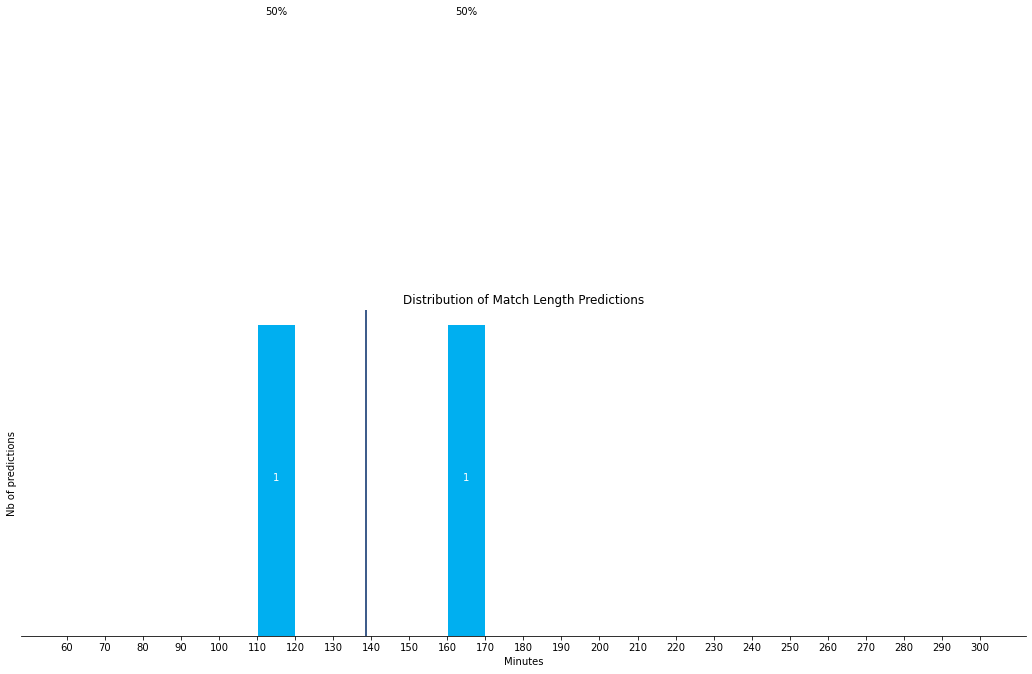

In [10]:
### HISTOGRAM ###

# ATP Colors
# Dark blue : #002865
# Light blue : #00AFF0

time_step = 10  # precision : 15/30/30 minutes
intervals=np.arange(60, 300 + time_step, time_step)

fig, ax = plt.subplots(1, figsize=(18,6))

n, bins, patches = plt.hist(predictions, bins=intervals, color='#00AFF0')

plt.xticks(bins)
plt.grid(color='white', lw = 1, axis='x')

plt.title('Distribution of Match Length Predictions')
plt.xlabel("Minutes")
plt.ylabel("Nb of predictions")

# ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
plt.yticks([])

for idx, value in enumerate(n) :
    if value > 0 :
        plt.text(xticks[idx], value + 1, f"{int(100 * value / iter)}%", ha='center')
        plt.text(xticks[idx], value / 2, int(value), ha='center', color='w')

plt.axvline(x=average_prediction, color='#002865')

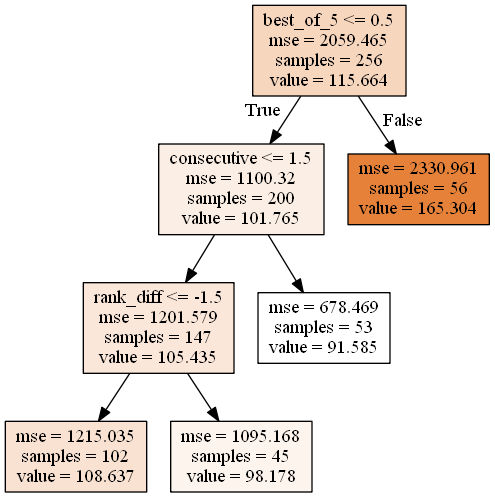

In [11]:
# TREE VISUALIZATION

# Without True/False (sklearn)

# x_ax = range(len(ytest))
# plt.plot(x_ax, ytest, linewidth=1, label="original")
# plt.plot(x_ax, ypred, linewidth=1.1, label="predicted")
# plt.title("Y-test and y-predicted data")
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.legend(loc='best',fancybox=True, shadow=True)
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(30,15))
# tree.plot_tree(dtr,
#           filled=True,
#           rounded=True,
#           fontsize=10,
#           feature_names=["opp_ht", "opp_age", "rank_diff", "consecutive", "surface_Carpet", "surface_Clay", "surface_Grass", "surface_Hard", 
#                          "best_of_3", "best_of_5", "opp_hand_L", "opp_hand_R", 
#                          'tourney_level_A', 'tourney_level_D', 'tourney_level_F', 'tourney_level_G', 'tourney_level_M', 
#                          'round_F', 'round_QF', 'round_R128', 'round_R16', 'round_R32', 'round_R64', 'round_RR', 'round_SF'])

# # plt.savefig('tree_high_dpi', dpi=600)

# # With True/False label (pydot)

from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydot

# def visualize_tree(dtr) :

features = list(player1.columns)
features.remove("minutes")

dot_data = StringIO()
export_graphviz(dtr, out_file=dot_data, feature_names=features, filled=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

# visualize_tree(dtr)